/usr/local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  plt.draw()
/usr/local/lib/python3.8/site-packages/geopandas/plotting.py:937: UserWarning: 

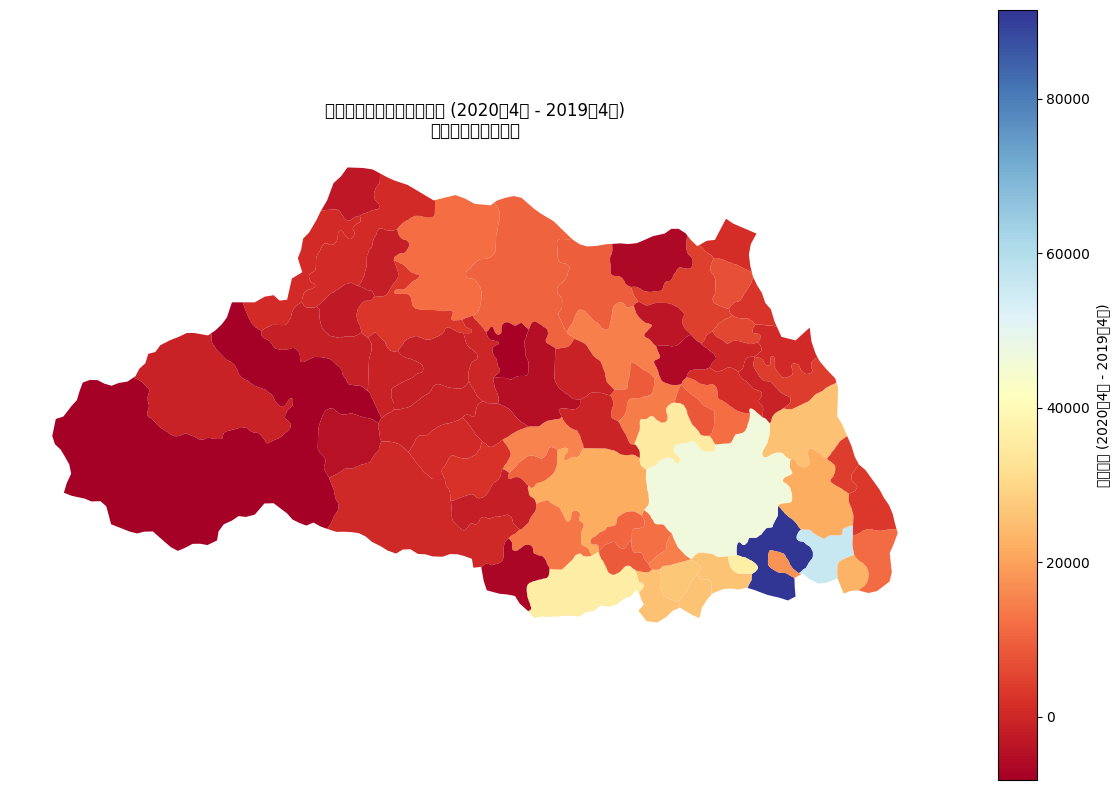

In [1]:
# F1. 埼玉県内市町村ごとの2019年4月の休日昼間人口と2020年4月の休日昼間人口の差（2020年マイナス2019年）を地図で示せ.

import pandas as pd
import geopandas as gpd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

# データベース接続
engine = create_engine('postgresql://postgres:postgres@db:5432/gisdb')

# 2019年と2020年の人口データを取得するSQLクエリ
query = """
WITH pop_2019 AS (
    SELECT a.name_2, 
           SUM(p.population) as pop_2019
    FROM adm2 a
    JOIN pop201904 p ON ST_Intersects(a.geom, p.geom)
    WHERE a.name_1 = 'Saitama'
    GROUP BY a.name_2
),
pop_2020 AS (
    SELECT a.name_2,
           SUM(p.population) as pop_2020
    FROM adm2 a
    JOIN pop202004 p ON ST_Intersects(a.geom, p.geom)
    WHERE a.name_1 = 'Saitama'
    GROUP BY a.name_2
)
SELECT 
    a.name_2,
    a.geom,
    COALESCE(p2020.pop_2020, 0) - COALESCE(p2019.pop_2019, 0) as pop_diff
FROM adm2 a
LEFT JOIN pop_2019 p2019 ON a.name_2 = p2019.name_2
LEFT JOIN pop_2020 p2020 ON a.name_2 = p2020.name_2
WHERE a.name_1 = 'Saitama'
ORDER BY pop_diff DESC;
"""

# クエリを実行してGeoDataFrameを作成
gdf = gpd.read_postgis(query, engine, geom_col='geom')

# 地図の作成
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
gdf.plot(column='pop_diff', 
        ax=ax,
        legend=True,
        legend_kwds={'label': '人口差分 (2020年4月 - 2019年4月)'},
        cmap='RdYlBu',
        missing_kwds={'color': 'lightgrey'})

# タイトルを追加
plt.title('埼玉県の市町村別人口差分 (2020年4月 - 2019年4月)\n休日昼間人口の比較')

# 軸ラベルを非表示
ax.axis('off')

plt.show()